In [73]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [74]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')



In [75]:
# 1.1 Read from source and get basic info
df_raw.info(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [76]:
# 1.2 Get a sample
df_raw.sample(5)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
77471,77471,Air_India,AI-867,Mumbai,Night,one,Night,Chennai,Economy,25.67,2,18753
261683,261683,Air_India,AI-729,Kolkata,Morning,one,Evening,Delhi,Business,8.83,9,42746
160009,160009,Vistara,UK-880,Hyderabad,Afternoon,one,Evening,Mumbai,Economy,5.67,13,10248
253223,253223,Air_India,AI-501,Bangalore,Afternoon,one,Evening,Kolkata,Business,5.83,8,60508
248270,248270,Air_India,AI-776,Bangalore,Early_Morning,one,Night,Delhi,Business,18.00,45,39847


In [ ]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres

    )
.rename(columns={'price':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:]


)



/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [95]:
np.isinf(df_interim['target']).sum()

np.int64(0)

In [96]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287770 entries, 0 to 300146
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   target            287770 non-null  float16
 1   airline           287770 non-null  object 
 2   flight            287770 non-null  object 
 3   source_city       287770 non-null  object 
 4   departure_time    287770 non-null  object 
 5   stops             287770 non-null  object 
 6   arrival_time      287770 non-null  object 
 7   destination_city  287770 non-null  object 
 8   class             287770 non-null  object 
 9   duration          287770 non-null  float64
 10  days_left         287770 non-null  int64  
dtypes: float16(1), float64(1), int64(1), object(8)
memory usage: 24.7+ MB


In [97]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230216 entries, 7626 to 198242
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   target            230216 non-null  float16
 1   airline           230216 non-null  object 
 2   flight            230216 non-null  object 
 3   source_city       230216 non-null  object 
 4   departure_time    230216 non-null  object 
 5   stops             230216 non-null  object 
 6   arrival_time      230216 non-null  object 
 7   destination_city  230216 non-null  object 
 8   class             230216 non-null  object 
 9   duration          230216 non-null  float64
 10  days_left         230216 non-null  int64  
dtypes: float16(1), float64(1), int64(1), object(8)
memory usage: 19.8+ MB


In [98]:
display(df_train.describe(include=object).T)
display(df_train.describe().T)

,count,unique,top,freq
airline,230216,6,Vistara,92566
flight,230216,1558,UK-706,2255
source_city,230216,6,Delhi,47443
departure_time,230216,6,Morning,53949
stops,230216,3,one,191301
arrival_time,230216,6,Night,69637
destination_city,230216,6,Delhi,44695
class,230216,2,Economy,165413


/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


,count,mean,std,min,25%,50%,75%,max
target,230216.0,NaN,0.000000,1105.00,4672.00,7052.00,35520.00,65504.00
duration,230216.0,12.152071,7.252112,0.83,6.67,11.17,16.17,49.83
days_left,230216.0,26.147344,13.507089,1.00,15.00,26.00,38.00,49.00


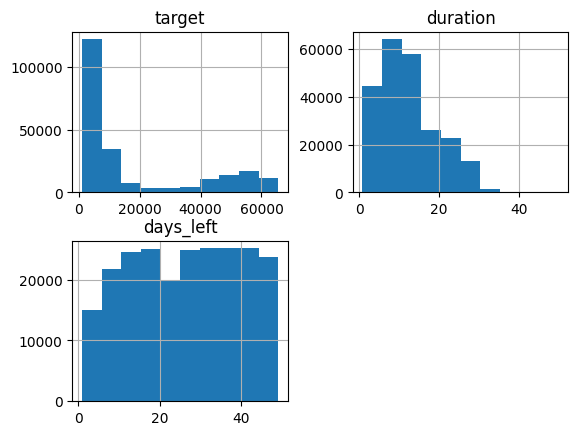

In [82]:
df_train.hist()
plt.show()